# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [182]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/s_metaheuristic/data/log


In [183]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [184]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [185]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [186]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [187]:
all_dfs = []
best_dfs = []
LOGs = str(LOG_PATH) + '/*.csv'

c = 0
for file in glob.glob(str(LOGs)):
    filename = file[file.find('/log/')+5:]
    try:
        df = pd.read_csv(file, low_memory=False, sep=',', quotechar='"')
        c = c + 1
    except:
        print('Arquivo não importado: {}'.format(filename))
    df['filename'] = filename
    df['X'] = df.X.str[1:-1].str.split().apply(lambda x: [float(y) for y in x])
    df['Z'] = df.Z.str[1:-1].str.split().apply(lambda x: [float(y) for y in x])
    df['Q'] = df.Z.apply(lambda x: np.sum(np.array(x)))
    all_dfs.append(df)
    best_dfs.append(df[df.iter==99])

all_data = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
all_data.rename({'move_strategy':'move_str',
                 'selection_strategy':'selec_str'}, axis=1, inplace=True)

best_data = pd.concat(best_dfs, ignore_index=True).reset_index(drop=True)
best_data.rename({'move_strategy':'move_str',
                  'selection_strategy':'selec_str'}, axis=1, inplace=True)

print('Importados {} arquivos'.format(c))

all_data.head()


Importados 1 arquivos


,iter,obj,aug_obj,return,X,Z,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,filename,Q
0,0,0.000483,0.000483,0.003534,"[0.081087, 0.06185, 0.068548, 0.0, 0.063901, 0...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0
1,1,0.000481,0.000481,0.003521,"[0.080182, 0.06116, 0.067783, 0.0, 0.063188, 0...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0
2,2,0.000477,0.000477,0.003520,"[0.080182, 0.06116, 0.067783, 0.0, 0.063188, 0...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0
3,3,0.000475,0.000475,0.003518,"[0.080827, 0.061652, 0.068329, 0.0, 0.063697, ...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0
4,4,0.000472,0.000472,0.003518,"[0.080827, 0.061652, 0.068329, 0.0, 0.063697, ...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0


In [188]:
all_data[all_data.obj=='[0.035848]']

,iter,obj,aug_obj,return,X,Z,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,filename,Q


In [189]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613200 entries, 0 to 613199
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   iter        613200 non-null  int64  
 1   obj         613200 non-null  float64
 2   aug_obj     613200 non-null  float64
 3   return      613200 non-null  float64
 4   X           613200 non-null  object 
 5   Z           613200 non-null  object 
 6   max_iter    613200 non-null  int64  
 7   neighbours  613200 non-null  int64  
 8   alpha       613200 non-null  float64
 9   exp_return  613200 non-null  float64
 10  n_port      613200 non-null  int64  
 11  k           613200 non-null  int64  
 12  move_str    613200 non-null  object 
 13  seed        613200 non-null  int64  
 14  selec_str   613200 non-null  object 
 15  filename    613200 non-null  object 
 16  Q           613200 non-null  float64
dtypes: float64(6), int64(6), object(5)
memory usage: 79.5+ MB


In [190]:
all_data.obj.value_counts()

0.000282    9900
0.001487    7200
0.000392    5400
0.001309    4800
0.002338    4200
            ... 
0.000038       1
0.000039       1
0.000040       1
0.000041       1
0.000021       1
Name: obj, Length: 115071, dtype: int64

In [191]:
all_data.iter.value_counts()

0      2044
206    2044
204    2044
203    2044
202    2044
201    2044
200    2044
199    2044
198    2044
197    2044
196    2044
195    2044
194    2044
193    2044
192    2044
191    2044
190    2044
205    2044
207    2044
188    2044
208    2044
223    2044
222    2044
221    2044
220    2044
219    2044
218    2044
217    2044
216    2044
215    2044
214    2044
213    2044
212    2044
211    2044
210    2044
209    2044
189    2044
187    2044
1      2044
168    2044
166    2044
165    2044
164    2044
163    2044
162    2044
161    2044
160    2044
159    2044
158    2044
157    2044
156    2044
155    2044
154    2044
153    2044
152    2044
167    2044
169    2044
186    2044
170    2044
185    2044
184    2044
183    2044
182    2044
181    2044
180    2044
179    2044
178    2044
177    2044
176    2044
175    2044
174    2044
173    2044
172    2044
171    2044
224    2044
225    2044
226    2044
281    2044
279    2044
278    2044
277    2044
276    2044
275    2044
274 

## Portfólios

### Geral

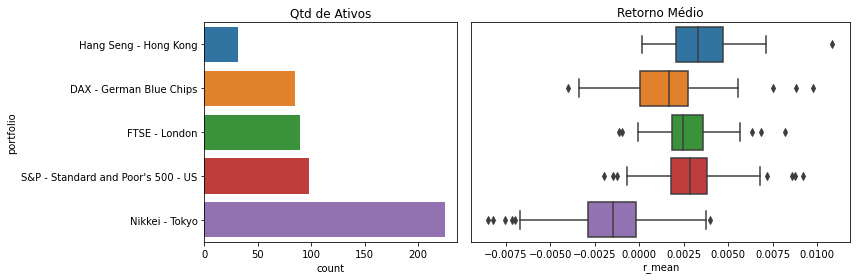

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

### Matriz de Covariância

In [193]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j].describe().T

,count,mean,std,min,25%,50%,75%,max
port,37904.0,4.336350,1.068738,1.000000,4.000000,5.000000,5.00000,5.000000
i,37904.0,60.152728,49.736086,1.000000,20.000000,46.000000,88.00000,224.000000
j,37904.0,120.305456,62.150969,2.000000,68.000000,113.000000,178.00000,225.000000
cov,37904.0,0.388782,0.166550,-0.145815,0.258983,0.419793,0.51717,0.909412


<AxesSubplot:>

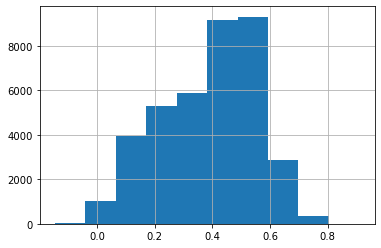

In [194]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j]['cov'].hist()

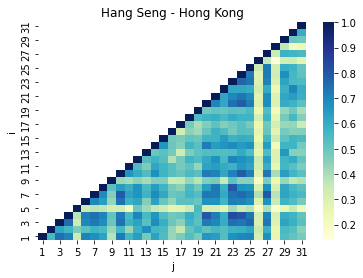

In [195]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [196]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


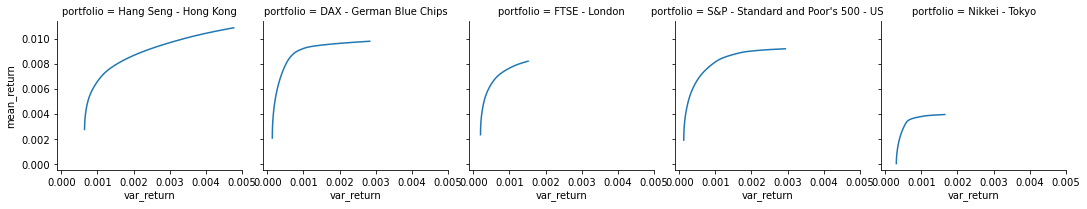

In [197]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

### Avaliação do Impacto da Seed

In [198]:
all_data.head()

,iter,obj,aug_obj,return,X,Z,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,filename,Q
0,0,0.000483,0.000483,0.003534,"[0.081087, 0.06185, 0.068548, 0.0, 0.063901, 0...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0
1,1,0.000481,0.000481,0.003521,"[0.080182, 0.06116, 0.067783, 0.0, 0.063188, 0...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0
2,2,0.000477,0.000477,0.003520,"[0.080182, 0.06116, 0.067783, 0.0, 0.063188, 0...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0
3,3,0.000475,0.000475,0.003518,"[0.080827, 0.061652, 0.068329, 0.0, 0.063697, ...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0
4,4,0.000472,0.000472,0.003518,"[0.080827, 0.061652, 0.068329, 0.0, 0.063697, ...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,20.0


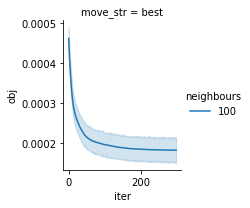

In [199]:
g = sns.FacetGrid(
    data=all_data, col='move_str', hue='neighbours')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

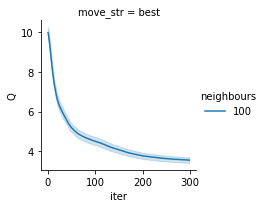

In [200]:
g = sns.FacetGrid(
    data=all_data, col='move_str', hue='neighbours')
g.map(sns.lineplot, 'iter', 'Q')
g.add_legend()
g=g

In [201]:
# g = sns.FacetGrid(
#     data=all_data, row='seed', col='selec_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Tipo de Move

In [202]:
# g = sns.FacetGrid(
#     data=all_data, row='selec_str', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Impacto do Retorno Experado

In [203]:
# g = sns.FacetGrid(
#     data=all_data, row='exp_return', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

## Análise Best - Portfólio 1

In [204]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [226]:
print(best_data.shape)
best_data.drop(['X', 'Z',],axis=1,).head()

(2044, 18)


,iter,obj,aug_obj,return,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,filename,Q,min_obj
0,99,0.000023,0.000023,0.001001,300,100,0.1,0.001,1,20,best,8,best,log_gls_20211116_175629_801715.csv,10.0,0.000003
1,99,0.000002,0.000002,0.003789,300,100,0.1,0.003,1,16,best,3,best,log_gls_20211116_175629_801715.csv,2.0,0.000002
2,99,0.000002,0.000002,0.002363,300,100,0.1,0.002,1,7,best,1,best,log_gls_20211116_175629_801715.csv,2.0,0.000002
3,99,0.000002,0.000002,0.002364,300,100,0.1,0.001,1,1,best,1,best,log_gls_20211116_175629_801715.csv,2.0,0.000002
4,99,0.000019,0.000019,0.000277,300,100,0.1,0.005,1,2,best,4,best,log_gls_20211116_175629_801715.csv,2.0,0.000004


In [206]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,2044.0,99.000000,0.000000e+00,9.900000e+01,99.000000,99.000000,99.000000,99.000000
obj,2044.0,0.000197,7.031540e-04,3.913343e-07,0.000002,0.000004,0.000064,0.005817
aug_obj,2044.0,0.000197,7.031540e-04,3.913343e-07,0.000002,0.000004,0.000064,0.005817
return,2044.0,0.003332,2.129161e-03,1.410000e-04,0.002006,0.003004,0.004712,0.010780
max_iter,2044.0,300.000000,0.000000e+00,3.000000e+02,300.000000,300.000000,300.000000,300.000000
neighbours,2044.0,100.000000,0.000000e+00,1.000000e+02,100.000000,100.000000,100.000000,100.000000
alpha,2044.0,0.100000,1.388118e-17,1.000000e-01,0.100000,0.100000,0.100000,0.100000
exp_return,2044.0,0.002975,1.978924e-03,1.000000e-03,0.002000,0.003000,0.004000,0.010000
n_port,2044.0,1.000000,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000
k,2044.0,10.144814,6.818360e+00,1.000000e+00,4.000000,9.500000,15.000000,31.000000


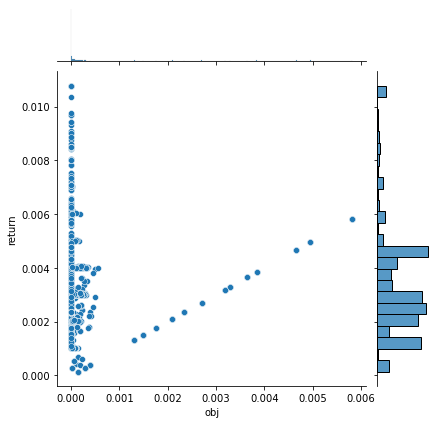

In [207]:
sns.jointplot(data=best_data, x='obj', y='return', palette='bright')

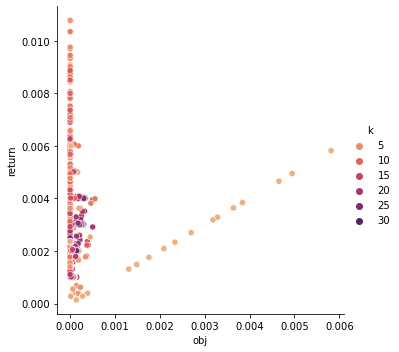

In [208]:
sns.relplot(data=best_data[best_data.obj<0.05], x='obj', y='return', hue='k', palette='flare')

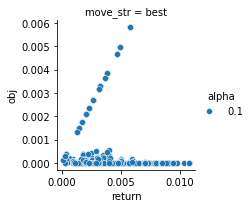

In [209]:
g = sns.FacetGrid(data=best_data, col='move_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

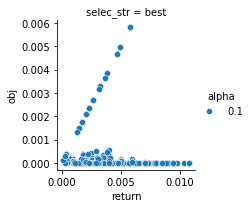

In [210]:
g = sns.FacetGrid(data=best_data, col='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

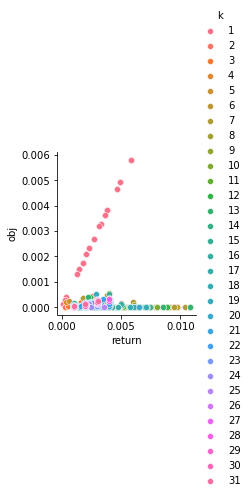

In [211]:
g = sns.FacetGrid(data=best_data, hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

In [212]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,2044.0,99.000000,0.000000e+00,9.900000e+01,99.000000,99.000000,99.000000,99.000000
obj,2044.0,0.000197,7.031540e-04,3.913343e-07,0.000002,0.000004,0.000064,0.005817
aug_obj,2044.0,0.000197,7.031540e-04,3.913343e-07,0.000002,0.000004,0.000064,0.005817
return,2044.0,0.003332,2.129161e-03,1.410000e-04,0.002006,0.003004,0.004712,0.010780
max_iter,2044.0,300.000000,0.000000e+00,3.000000e+02,300.000000,300.000000,300.000000,300.000000
neighbours,2044.0,100.000000,0.000000e+00,1.000000e+02,100.000000,100.000000,100.000000,100.000000
alpha,2044.0,0.100000,1.388118e-17,1.000000e-01,0.100000,0.100000,0.100000,0.100000
exp_return,2044.0,0.002975,1.978924e-03,1.000000e-03,0.002000,0.003000,0.004000,0.010000
n_port,2044.0,1.000000,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000
k,2044.0,10.144814,6.818360e+00,1.000000e+00,4.000000,9.500000,15.000000,31.000000


In [213]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [214]:
uef[uef.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_return,2000.0,0.006825,0.002334,0.002784,0.004804,0.006825,0.008845,0.010865
var_return,2000.0,0.001579,0.001116,0.000642,0.000716,0.001058,0.002150,0.004776
port,2000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'mean_return')

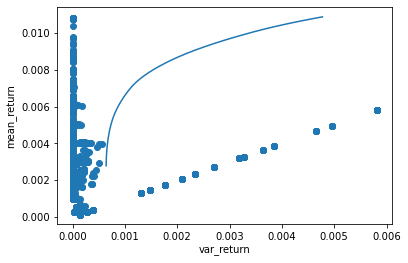

In [215]:
data = best_data[best_data['obj']<0.05]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [216]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,2044.0,99.000000,0.000000e+00,9.900000e+01,99.000000,99.000000,99.000000,99.000000
obj,2044.0,0.000197,7.031540e-04,3.913343e-07,0.000002,0.000004,0.000064,0.005817
aug_obj,2044.0,0.000197,7.031540e-04,3.913343e-07,0.000002,0.000004,0.000064,0.005817
return,2044.0,0.003332,2.129161e-03,1.410000e-04,0.002006,0.003004,0.004712,0.010780
max_iter,2044.0,300.000000,0.000000e+00,3.000000e+02,300.000000,300.000000,300.000000,300.000000
neighbours,2044.0,100.000000,0.000000e+00,1.000000e+02,100.000000,100.000000,100.000000,100.000000
alpha,2044.0,0.100000,1.388118e-17,1.000000e-01,0.100000,0.100000,0.100000,0.100000
exp_return,2044.0,0.002975,1.978924e-03,1.000000e-03,0.002000,0.003000,0.004000,0.010000
n_port,2044.0,1.000000,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000
k,2044.0,10.144814,6.818360e+00,1.000000e+00,4.000000,9.500000,15.000000,31.000000


In [217]:
best_data['min_obj'] = best_data.groupby(['exp_return', 'k'])['obj'].transform(min)
best_best_data = best_data[best_data.obj==best_data.min_obj]
print(best_best_data.shape)
best_best_data.head(30)


(186, 18)


,iter,obj,aug_obj,return,X,Z,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,filename,Q,min_obj
8,99,3.298225e-06,3.298225e-06,0.008628,"[0.0, 0.0, 0.0, 0.0, 0.79192882, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.006,1,8,best,9,best,log_gls_20211116_175629_801715.csv,2.0,3.298225e-06
16,99,2.325536e-06,2.325536e-06,0.006090,"[0.0, 0.0, 0.0, 0.0, 0.55837877, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.006,1,17,best,18,best,log_gls_20211116_175629_801715.csv,2.0,2.325536e-06
24,99,1.222679e-06,1.222679e-06,0.002587,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.002,1,19,best,18,best,log_gls_20211116_175629_801715.csv,2.0,1.222679e-06
48,99,3.079552e-06,3.079552e-06,0.008057,"[0.0, 0.0, 0.0, 0.0, 0.73942376, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.005,1,10,best,12,best,log_gls_20211116_175629_801715.csv,2.0,3.079552e-06
55,99,2.403866e-06,2.403866e-06,0.004767,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.003,1,15,best,18,best,log_gls_20211116_175629_801715.csv,2.0,2.403866e-06
73,99,3.958888e-07,3.958888e-07,0.001056,"[0.0, 0.0, 0.0, 0.0, 0.0950559, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.001,1,17,best,2,best,log_gls_20211116_175629_801715.csv,2.0,3.958888e-07
81,99,2.781929e-06,2.781929e-06,0.007281,"[0.0, 0.0, 0.0, 0.0, 0.66796241, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.007,1,11,best,12,best,log_gls_20211116_175629_801715.csv,2.0,2.781929e-06
93,99,1.104659e-06,1.104659e-06,0.002339,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.002,1,13,best,0,best,log_gls_20211116_175629_801715.csv,2.0,1.104659e-06
99,99,2.521744e-06,2.521744e-06,0.006602,"[0.0, 0.0, 0.0, 0.0, 0.60548998, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.006,1,15,best,20,best,log_gls_20211116_175629_801715.csv,2.0,2.521744e-06
100,99,2.262056e-06,2.262056e-06,0.004766,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",300,100,0.1,0.004,1,1,best,19,best,log_gls_20211116_175629_801715.csv,2.0,2.262056e-06


In [219]:
mask = (df_stats.port==1) & (df_stats.i==17)
df_stats[mask]

,port,i,r_mean,r_std,portfolio
16,1,17,0.000282,0.04398,Hang Seng - Hong Kong


Text(0, 0.5, 'mean_return')

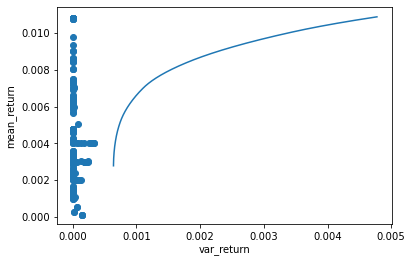

In [220]:
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(best_best_data.obj, best_best_data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

Text(0, 0.5, 'mean_return')

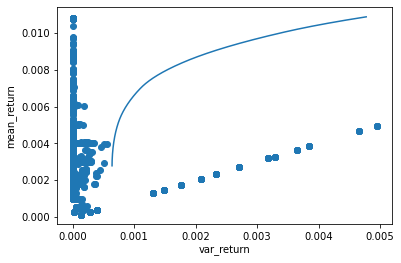

In [221]:
data = best_data[best_data['obj']<0.005]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [222]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

,exp_return,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010
move_str,selec_str,,,,,,,,,,
best,best,506,497,464,245,102,74,72,32,26,26


In [223]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

,exp_return,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010
move_str,selec_str,,,,,,,,,,
best,best,3.913343e-07,7.778511e-07,0.000001,0.000002,0.000002,0.000002,0.000003,0.000004,0.000019,0.000019


In [224]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(10, 2)


,exp_return,obj
0,0.001,3.913343e-07
1,0.002,7.778511e-07
2,0.003,1.424193e-06
3,0.004,1.901520e-06
4,0.005,2.184205e-06


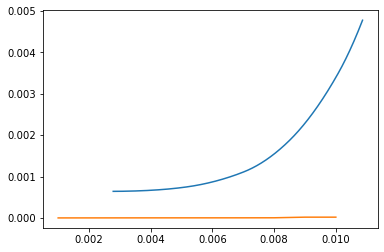

In [225]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)